In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install imdlib
!pip install pymannkendall

# Downloading data

In [6]:
# Downloading IMD data
path_data = "/content/drive/MyDrive/P2P_session"

In [7]:
import imdlib as imd
import numpy as np
import matplotlib.pyplot as plt
import pymannkendall as mk

In [8]:
start_yr = 2001
end_yr = 2020
variable = 'rain' # other options are ('tmin'/ 'tmax')
file_dir = (path_data) #Path to save the files
# imd.get_data(variable, start_yr, end_yr, fn_format='yearwise', file_dir=file_dir)

# Plotting

In [9]:
data = imd.open_data(variable, start_yr, end_yr,'yearwise', file_dir)
ds = data.get_xarray()

In [10]:
ds.rain

<xarray.DataArray 'rain' (time: 7305, lat: 129, lon: 135)> Size: 1GB
array([[[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
...
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]],

       [[-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        ...,
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.],
        [-999., -999., -999., ..., -999., -999., -999.]]])
Coordinates:
  * lat      (lat) float64 1kB 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * lon      (lon) float64 1kB 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 58kB 2001-01-01 2001-01-02 ... 2020-12-31
Attributes:
    units:      mm/day
    long_name:  Rainfall

In [11]:
lon = ds.rain.lon
lat = ds['rain'].lat
da = ds.where(ds.rain != -999.) #Remove NaN values

In [14]:
data.to_netcdf('test.nc', file_dir)


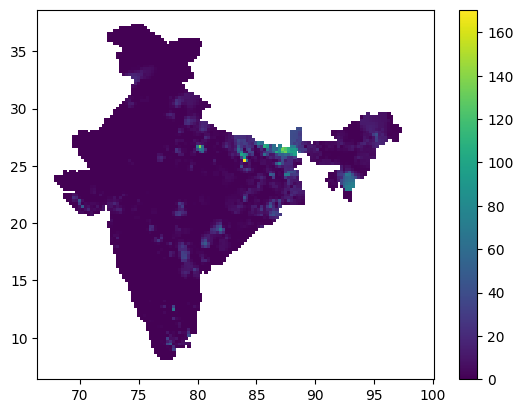

In [ ]:
plt.figure()
plt.pcolor(lon, lat, da.rain[255, :, :],
          #  vmax= 20,
          #  vmin = 0,
          #  cmap = "Blues"
           );
plt.colorbar()


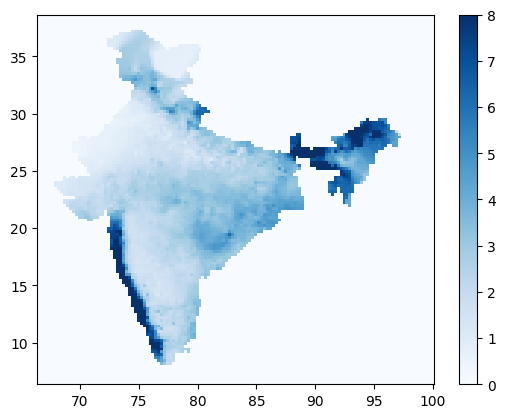

In [ ]:
plt.figure()
plt.pcolor(lon, lat, ds.rain.mean(dim="time"),
           vmax= 8,
           vmin = 0,
           cmap = "Blues");
plt.colorbar()


# Slicing

In [ ]:
ds.sel(time="2013-05")

In [ ]:
ds.sel(time=slice("2013-05", "2013-07"))


In [ ]:
ds_delhi_annual = ds.sel(lon=77.1025,lat = 28.7, method="nearest").groupby("time.year").sum()

jjas_prec  = ds_delhi_annual.rain.data
# ds_delhi = ds.sel(lon=77.1025,lat = 28.7, method="nearest")
# ds_jjas =ds_delhi.where(ds_delhi.time.dt.month.isin([4,5,6,7]), drop=True).groupby("time.year").sum()
# ds_selected
# jjas_prec  = ds_jjas.rain.data

# Trend analysis for a point location

In [ ]:
def plot_trend(data_trend,c):
    N=data_trend.shape[0]
    result = mk.original_test(data_trend)
    print(str(np.round(result.slope/np.mean(data_trend)*41*100*1000)/1000)+ '% in '+str(N)+' years (p=' + str(np.round(result.p*1000)/1000)+')')
#     plt.plot(data_trend)
    plt.plot(np.mean(data_trend)+np.arange(N) * result.slope - N*0.5* result.slope, c )


plt.figure(figsize=(10,5))
plt.plot(jjas_prec,':k')
plot_trend(jjas_prec,'b')
plt.title('Sum of JJAS Precipitation')


In [ ]:
plt.pcolor(ds_jjas[0,:,:])

# Gridwise trend analysis

In [ ]:
da = ds.where(ds.rain != -999.) #Remove NaN values
ds_jjas =da.where(da.time.dt.month.isin([4,5,6,7]), drop=True).groupby("time.year").sum().rain.data
mask = ds.rain.mean(dim="time").data >0
mask = np.where(mask, 1,np.nan)


In [ ]:
_,N1,N2 = ds_jjas.shape
slope_monthly=np.zeros((N1,N2))*np.nan
pval_monthly=np.zeros((N1,N2))*np.nan

for n1 in range(N1):
    for n2 in range(N2):
        if np.sum(np.isnan(ds_jjas[:,n1,n2])) < 1:
            data_trend=ds_jjas[:,n1,n2]

            N=data_trend.shape[0]
            result = mk.original_test(data_trend)
            slope_monthly[n1,n2]=np.round(result.slope*N*1000)/1000
            pval_monthly[n1,n2]=np.round(result.p*1000)/1000



In [ ]:
im=plt.gca().pcolor(lon,lat,slope_monthly*mask,
                    cmap= 'RdBu',
                    vmax= 500,
                    vmin =-500
                    )

plt.colorbar(im)
plt.contourf(lon,lat,pval_monthly,
            cmap=None,extend='both',
             levels=[0.01,1],hatches=['xxx',None],
            colors='none')




# Reading NC files

In [16]:
import xarray as xr

In [20]:
# pip install netcdf4

In [34]:
data_from_nc_1 = xr.open_dataset("/content/drive/MyDrive/P2P_session/IMD_rainfall_nc/rainfall_2000.nc")
data_from_nc_2 = xr.open_dataset("/content/drive/MyDrive/P2P_session/IMD_rainfall_nc/rainfall_2001.nc")
data_from_nc_1,data_from_nc_2

(<xarray.Dataset> Size: 3MB
 Dimensions:    (LONGITUDE: 35, LATITUDE: 33, TIME: 366)
 Coordinates:
   * LONGITUDE  (LONGITUDE) float64 280B 66.5 67.5 68.5 69.5 ... 98.5 99.5 100.5
   * LATITUDE   (LATITUDE) float64 264B 6.5 7.5 8.5 9.5 ... 35.5 36.5 37.5 38.5
   * TIME       (TIME) datetime64[ns] 3kB 2000-01-01 2000-01-02 ... 2000-12-31
 Data variables:
     RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 3MB ...
 Attributes:
     history:      FERRET V7.5 (optimized) 28-Mar-22
     Conventions:  CF-1.6,
 <xarray.Dataset> Size: 3MB
 Dimensions:    (LONGITUDE: 35, LATITUDE: 33, TIME: 365)
 Coordinates:
   * LONGITUDE  (LONGITUDE) float64 280B 66.5 67.5 68.5 69.5 ... 98.5 99.5 100.5
   * LATITUDE   (LATITUDE) float64 264B 6.5 7.5 8.5 9.5 ... 35.5 36.5 37.5 38.5
   * TIME       (TIME) datetime64[ns] 3kB 2001-01-01 2001-01-02 ... 2001-12-31
 Data variables:
     RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 3MB ...
 Attributes:
     history:      FERRET V7.5 (optimized) 28-Mar-22
     Conv

In [31]:
combined_ = xr.concat([data_from_nc_1, data_from_nc_2], dim="TIME")

In [32]:
combined_

<xarray.Dataset> Size: 7MB
Dimensions:    (TIME: 731, LATITUDE: 33, LONGITUDE: 35)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 280B 66.5 67.5 68.5 69.5 ... 98.5 99.5 100.5
  * LATITUDE   (LATITUDE) float64 264B 6.5 7.5 8.5 9.5 ... 35.5 36.5 37.5 38.5
  * TIME       (TIME) datetime64[ns] 6kB 2000-01-01 2000-01-02 ... 2001-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 7MB nan nan nan ... nan nan
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6